# 1. Imports

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm


# 2. Merging datasets

## Seaship

In [25]:
source = 'sea_ship/seaship.v1i.yolov8/test/images'
source_1 = 'sea_ship/seaship.v1i.yolov8/train/images'
destination = 'merged_dataset/images'

# gather all files
allfiles = os.listdir(source)
allfiles_1 = os.listdir(source_1)

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_1:
    src_path = os.path.join(source_1, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)
    

In [26]:
source_labels = 'sea_ship/seaship.v1i.yolov8/test/labels'
source_1_labels = 'sea_ship/seaship.v1i.yolov8/train/labels'
destination = 'merged_dataset/labels'

# gather all files
allfiles = os.listdir(source_labels)
allfiles_1 = os.listdir(source_1_labels)

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source_labels, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_1:
    src_path = os.path.join(source_1_labels, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

## Singapore Maritime Dataset 

### Replacing numbering of the labels

In [9]:
class_mapping = {0: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12, 7: 13, 8: 14}

input_dir = "Singapore maritime.v5i.yolov8/valid/labels"
output_dir = "Singapore maritime.v5i.yolov8/valid/labels_new"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(input_dir, filename), 'r') as f_in, \
             open(os.path.join(output_dir, filename), 'w') as f_out:
            for line in f_in:
                parts = line.strip().split()
                if parts:
                    old_class = int(parts[0])
                    new_class = class_mapping.get(old_class, old_class)
                    parts[0] = str(new_class)
                    f_out.write(' '.join(parts) + '\n')

## Moving the images and labels to the desired location

In [11]:
source = "Singapore maritime.v5i.yolov8/train/images"
source_1 = "Singapore maritime.v5i.yolov8/valid/images"
source_2 = "Singapore maritime.v5i.yolov8/test/images"
destination = "merged_dataset/images"

# gather all files
allfiles = os.listdir(source)
allfiles_1 = os.listdir(source_1)
allfiles_2 = os.listdir(source_2)

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_1:
    src_path = os.path.join(source_1, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_2:
    src_path = os.path.join(source_2, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)
    

In [12]:
source = "Singapore maritime.v5i.yolov8/train/labels_new"
source_1 = "Singapore maritime.v5i.yolov8/valid/labels_new"
source_2 = "Singapore maritime.v5i.yolov8/test/labels_new"
destination = "merged_dataset/labels"

# gather all files
allfiles = os.listdir(source)
allfiles_1 = os.listdir(source_1)
allfiles_2 = os.listdir(source_2)

# iterate on all files to move them to destination folder
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_1:
    src_path = os.path.join(source_1, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

for f in allfiles_2:
    src_path = os.path.join(source_2, f)
    dst_path = os.path.join(destination, f)
    os.rename(src_path, dst_path)

# 2. Data exploration

## Building up the dataframe w/ current files

In [3]:
import glob
import os
import pandas as pd

# Directory containing label .txt files
labels_dir = 'merged_dataset/labels'
files = sorted(glob.glob(os.path.join(labels_dir, '*.txt')))

rows = []
if not files:
    # No label files found: create an empty dataframe with expected columns
    print('No label files found in', labels_dir)
    labels_df = pd.DataFrame(columns=['label_file', 'image_file', 'class', 'x', 'y', 'w', 'h'])
else:
    for fp in files:
        basename = os.path.basename(fp)
        image_name = os.path.splitext(basename)[0] + '.jpg'
        # read non-empty lines
        with open(fp, 'r', encoding='utf-8') as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip() != '']
        if not lines:
            # file had no labels; create one row with NaNs for class and coords
            rows.append({
                'label_file': basename,
                'image_file': image_name,
                'class': pd.NA,
                'x': pd.NA,
                'y': pd.NA,
                'w': pd.NA,
                'h': pd.NA
            })
        else:
            for ln in lines:
                parts = ln.split()
                # YOLO format: class x_center y_center width height
                try:
                    cls = int(parts[0]) if len(parts) >= 1 else pd.NA
                except ValueError:
                    cls = pd.NA
                coords = [pd.NA, pd.NA, pd.NA, pd.NA]
                if len(parts) >= 5:
                    try:
                        coords = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                    except ValueError:
                        coords = [pd.NA, pd.NA, pd.NA, pd.NA]
                rows.append({
                    'label_file': basename,
                    'image_file': image_name,
                    'class': cls,
                    'x': coords[0],
                    'y': coords[1],
                    'w': coords[2],
                    'h': coords[3],
                })
    # build dataframe from parsed rows
    labels_df = pd.DataFrame(rows)

# compute summary stats
total_files = len(files)
total_boxes = int(labels_df['class'].notna().sum()) if not labels_df.empty else 0
empty_label_files = int(labels_df.loc[labels_df['class'].isna(), 'label_file'].nunique()) if not labels_df.empty else 0
print(f'Total label files scanned: {total_files}')
print(f'Total bounding boxes (rows): {total_boxes}')
print(f'Empty label files: {empty_label_files}')

# show a sample preview
labels_df.head(10)

Total label files scanned: 13329
Total bounding boxes (rows): 57515
Empty label files: 83


,label_file,image_file,class,x,y,w,h
0,000001_jpg.rf.a030cdccc38ea75b40886ab22a6bb414...,000001_jpg.rf.a030cdccc38ea75b40886ab22a6bb414...,4,0.410156,0.451389,0.161979,0.039815
1,000002_jpg.rf.f34ffd48a87c63f8dd719db1caafe9de...,000002_jpg.rf.f34ffd48a87c63f8dd719db1caafe9de...,4,0.558333,0.461574,0.186458,0.047222
2,000003_jpg.rf.6c421cbf23a578007341ba53c456e29e...,000003_jpg.rf.6c421cbf23a578007341ba53c456e29e...,4,0.54401,0.459722,0.183854,0.043519
3,000004_jpg.rf.575252f879c2e9a9936a8fcea7442c29...,000004_jpg.rf.575252f879c2e9a9936a8fcea7442c29...,4,0.8875,0.505556,0.177083,0.05
4,000005_jpg.rf.40de319875226569bd91d448d071c2db...,000005_jpg.rf.40de319875226569bd91d448d071c2db...,4,0.809115,0.499074,0.166146,0.042593
5,000006_jpg.rf.7ed6bb3399639d916d897014c842484c...,000006_jpg.rf.7ed6bb3399639d916d897014c842484c...,4,0.526042,0.460185,0.178125,0.05
6,000007_jpg.rf.34d08bc4f25858287a291f52dd5f4725...,000007_jpg.rf.34d08bc4f25858287a291f52dd5f4725...,4,0.634115,0.469907,0.222396,0.058333
7,000008_jpg.rf.200d753625fd61bb308c95e804144e49...,000008_jpg.rf.200d753625fd61bb308c95e804144e49...,4,0.615625,0.466667,0.205208,0.055556
8,000009_jpg.rf.f10dbae55ebeda058fa23fefe3fbb25f...,000009_jpg.rf.f10dbae55ebeda058fa23fefe3fbb25f...,4,0.594792,0.465741,0.202083,0.05
9,000010_jpg.rf.d6e4cc8e2f9cb55462f3ce58a55ef35d...,000010_jpg.rf.d6e4cc8e2f9cb55462f3ce58a55ef35d...,4,0.829688,0.485185,0.339583,0.072222


## Summing up and plotting the class distribution

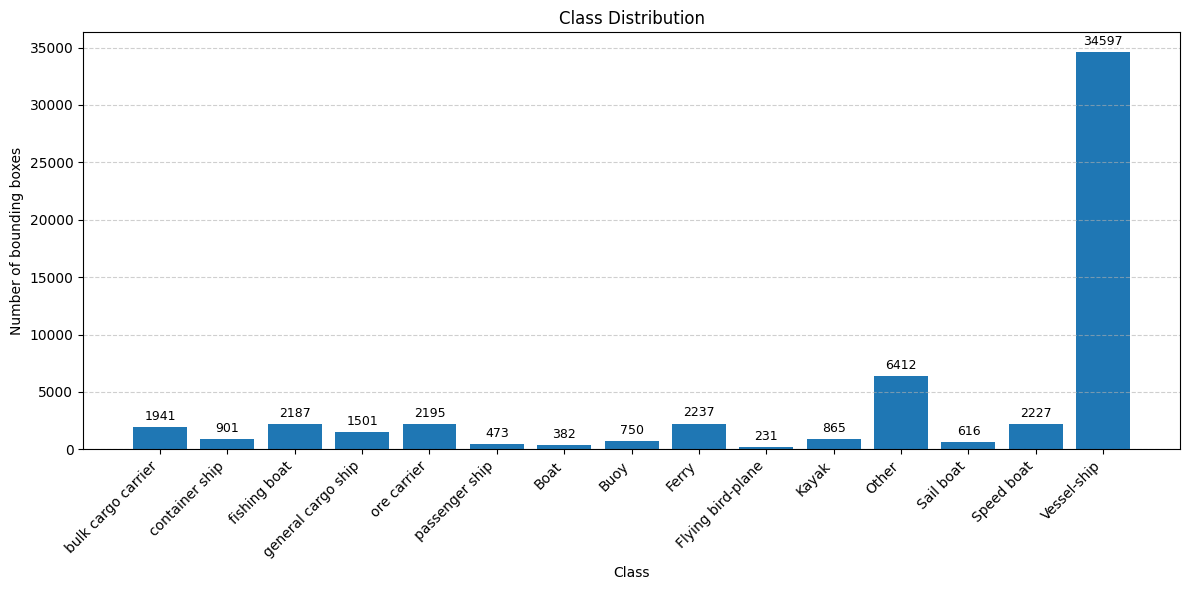

In [4]:
# Try to load class names from merged_dataset/data.yaml
class_names = {}
data_yaml_path = 'merged_dataset/data.yaml'
if os.path.exists(data_yaml_path):
    try:
        import yaml
        with open(data_yaml_path, 'r', encoding='utf-8') as f:
            data = yaml.safe_load(f)
        names = data.get('names') if isinstance(data, dict) else None
        if isinstance(names, dict):
            # keys may be strings; convert to ints
            class_names = {int(k): v for k, v in names.items()}
        elif isinstance(names, list):
            class_names = {i: n for i, n in enumerate(names)}
    except Exception:
        # fallback: simple parse for a YAML 'names' block
        try:
            with open(data_yaml_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            names_list = []
            in_names = False
            for ln in lines:
                s = ln.strip()
                if s.startswith('names:'):
                    # might be inline list or start of block
                    rest = s.split('names:', 1)[1].strip()
                    if rest.startswith('['):
                        # literal list, try eval safely
                        import ast
                        try:
                            names_list = ast.literal_eval(rest)
                        except Exception:
                            names_list = []
                        break
                    else:
                        in_names = True
                        continue
                if in_names:
                    if s.startswith('-'):
                        names_list.append(s.lstrip('-').strip().strip('"'))
                    else:
                        break
            class_names = {i: n for i, n in enumerate(names_list)}
        except Exception:
            class_names = {}
else:
    print(f'No data.yaml at {data_yaml_path}; falling back to numeric class IDs')

# If labels_df is empty or has no class entries, show message
if 'labels_df' not in globals() or labels_df.empty or labels_df['class'].dropna().empty:
    print('No labeled bounding boxes to plot.')
else:
    counts = labels_df['class'].dropna().astype(int).value_counts().sort_index()
    idx = list(counts.index)
    vals = counts.values
    x_labels = [class_names.get(i, str(i)) for i in idx]
    plt.figure(figsize=(12,6))
    bars = plt.bar(x_labels, vals, color='tab:blue')
    plt.title('Class Distribution')
    plt.ylabel('Number of bounding boxes')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    # annotate counts on bars
    for bar in bars:
        h = bar.get_height()
        plt.annotate(f'{int(h)}', xy=(bar.get_x() + bar.get_width() / 2, h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()


## Creating video with ground truth

In [2]:
# Paths - adjust these to your setup
images_dir = "merged_dataset/images"
labels_dir = "merged_dataset/labels"
output_video = "ground_truth_video_singapore_maritime.mp4"

# Class names dictionary (adjust based on your dataset)
class_names = {
    0: "bulk cargo carrier",
    1: "container ship",
    2: "fishing boat",
    3: "general cargo ship",
    4: "ore carrier",
    5: "passenger ship",
    6: "Boat",
    7: "Buoy",
    8: "Ferry",
    9: "Flying bird-plane",
    10: "Kayak",
    11: "Other",
    12: "Sail boat",
    13: "Speed boat",
    14: "Vessel-ship",
}

# Filter only Singapore Maritime dataset images (they start with 'MVI')
image_files = sorted(glob.glob(os.path.join(images_dir, "MVI*.jpg")))
# Try other extensions if needed
if not image_files:
    image_files = sorted(glob.glob(os.path.join(images_dir, "MVI*.png")))

# Check if we found any images
if not image_files:
    print("No Singapore Maritime dataset images found!")
else:
    # Read first image to get dimensions
    first_img = cv2.imread(image_files[0])
    height, width = first_img.shape[:2]
    
    # Define the output video writer using mp4v codec, 30fps
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, 30.0, (width, height))
    
    # Process each image
    print(f"Processing {len(image_files)} images...")
    
    for idx, img_path in enumerate(image_files):
        # Print progress message
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(image_files)} images")
        
        # Read the image
        img = cv2.imread(img_path)
        
        # Skip if image couldn't be loaded
        if img is None:
            print(f"Warning: Could not load {img_path}")
            continue
        
        # Get corresponding label file
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_dir, f"{img_name}.txt")
        
        # Get all bounding boxes for this image
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    
                    # Skip if no class information
                    if len(parts) < 5:
                        continue
                    
                    class_id = int(parts[0])
                    x_center, y_center, box_width, box_height = map(
                        float, parts[1:5]
                    )
                    
                    # Convert YOLO format to pixel coordinates
                    x_center_px = int(x_center * width)
                    y_center_px = int(y_center * height)
                    box_width_px = int(box_width * width)
                    box_height_px = int(box_height * height)
                    
                    # Calculate the corner points from center, width, height
                    x1 = int(x_center_px - box_width_px / 2)
                    y1 = int(y_center_px - box_height_px / 2)
                    x2 = int(x_center_px + box_width_px / 2)
                    y2 = int(y_center_px + box_height_px / 2)
                    
                    # Draw rectangle (green color)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Get class name if available from the class_names dict
                    class_label = class_names.get(class_id, f"Class_{class_id}")
                    
                    # Put class name text above the box
                    cv2.putText(
                        img, class_label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
                    )
        
        # Write frame to video
        out.write(img)
    
    # Release the video writer
    out.release()
    print(f"Video saved to {output_video}")
    print(f"Total frames: {len(image_files)}")

Processing 6350 images...
Processed 10/6350 images
Processed 20/6350 images
Processed 30/6350 images
Processed 40/6350 images
Processed 50/6350 images
Processed 60/6350 images
Processed 70/6350 images
Processed 80/6350 images
Processed 90/6350 images
Processed 100/6350 images
Processed 110/6350 images
Processed 120/6350 images
Processed 130/6350 images
Processed 140/6350 images
Processed 150/6350 images
Processed 160/6350 images
Processed 170/6350 images
Processed 180/6350 images
Processed 190/6350 images
Processed 200/6350 images
Processed 210/6350 images
Processed 220/6350 images
Processed 230/6350 images
Processed 240/6350 images
Processed 250/6350 images
Processed 260/6350 images
Processed 270/6350 images
Processed 280/6350 images
Processed 290/6350 images
Processed 300/6350 images
Processed 310/6350 images
Processed 320/6350 images
Processed 330/6350 images
Processed 340/6350 images
Processed 350/6350 images
Processed 360/6350 images
Processed 370/6350 images
Processed 380/6350 im